Minimalist implementation of **Focal Loss for Dense Object Detection**, applied to the PascalVOC dataset and trained from scratch.


### [Paper](https://arxiv.org/abs/1708.02002.pdf)

## Imports

In [ ]:
import time

import torch
import numpy as np
import torch.nn as nn
from torchvision.ops import nms
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from matplotlib import patheffects
from torchvision import transforms
from torchvision.ops import box_iou
from torch.utils.data import DataLoader
from matplotlib.patches import Rectangle
from torchvision.datasets import VOCDetection
from torchvision.transforms import functional as TF
from torchvision.models.resnet import ResNet50_Weights

# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {device}")

Using cuda:0


## Utilities

In [ ]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

VOC_CLASSES_DICT = {value: idx for idx, value in enumerate(VOC_CLASSES)}

colors = np.random.rand(len(VOC_CLASSES))
cmap = plt.cm.RdYlBu_r
VOC_CMAP = cmap(colors)


In [ ]:
def draw_image_boxes(image, boxes, classes):
    fig, ax = plt.subplots(figsize=(6, 9))
    ax.imshow(image.permute(1, 2, 0))

    for idx, bbox in enumerate(boxes):
        cls = classes[idx].long()

        right = bbox[0] + bbox[2] * 0.25 # Move a bit to left 
        top = bbox[1] - bbox[3] * 0.5
        ax.add_patch(
            Rectangle(
                (bbox[0] - bbox[2] * 0.5, bbox[1] - bbox[3] * 0.5),
                bbox[2],
                bbox[3],
                fill=False,
                edgecolor=VOC_CMAP[cls],
                lw=2,
            )
        )
        ax.text(
            right,
            top,
            VOC_CLASSES[cls],
            verticalalignment="bottom",
            color="white",
            fontsize=10,
            weight="bold",
        ).set_path_effects(
            [patheffects.Stroke(linewidth=4, foreground="black"), patheffects.Normal()]
        )

def coordinates_to_center_hw(boxes):
    """
    Convert from (upper-left, lower-right) to (center_x, center_y, width, height)
    """
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes


def center_hw_to_xy_minmax(boxes):
    """
    Convert from (center, width, height) to (upper-left, lower-right)
    """
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes


## Dataset

Custom transforms to be applied both to the images and targets.

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)

        return image, target


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = TF.resize(image, self.size)

        return image, target


class ToTensor(object):
    # Converts a row in the dataset into input and target tensors and applies normalization if provided.
    def __init__(self, mean=None, std=None):
      self.normalization = None
      if mean:
        self.normalization = transforms.Normalize(mean, std)

    def __call__(self, image, target):
        image = TF.to_tensor(image)
        parsed_targets = []

        old_image_width = float(target["annotation"]["size"]["width"])
        old_image_height = float(target["annotation"]["size"]["height"])

        scale_x = image.shape[1] / old_image_width
        scale_y = image.shape[2] / old_image_height
        objects = target["annotation"]["object"]
        for current_obj in objects:
            cls = VOC_CLASSES_DICT[current_obj["name"]]

            # Apply resizing to target
            x_max = float(current_obj["bndbox"]["xmax"]) * scale_x
            y_max = float(current_obj["bndbox"]["ymax"]) * scale_y
            x_min = float(current_obj["bndbox"]["xmin"]) * scale_x
            y_min = float(current_obj["bndbox"]["ymin"]) * scale_y
            parsed_targets.append([cls, x_min, y_min, x_max, y_max])
        
        if self.normalization is not None:
          image = self.normalization(image)

        return image, torch.tensor(parsed_targets)


In [ ]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

basic_augmentation = Compose(
    [
        Resize((256, 256)),
        ToTensor(imagenet_mean, imagenet_std),
    ]
)

train_data = VOCDetection(
    "sample_data", download=True, transforms=basic_augmentation
)

train_data, test_data = torch.utils.data.random_split(train_data, [0.8, 0.2])

Using downloaded and verified file: sample_data/VOCtrainval_11-May-2012.tar
Extracting sample_data/VOCtrainval_11-May-2012.tar to sample_data


### Show some images

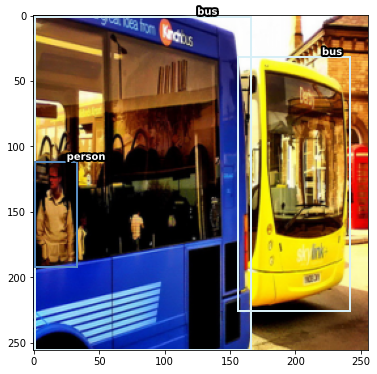

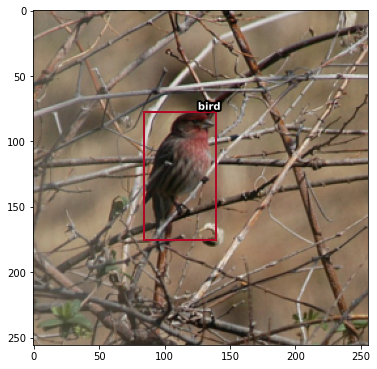

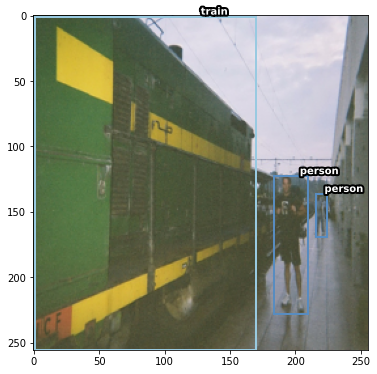

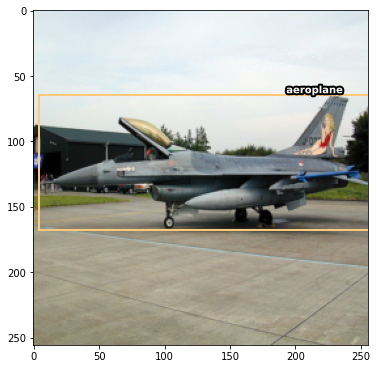

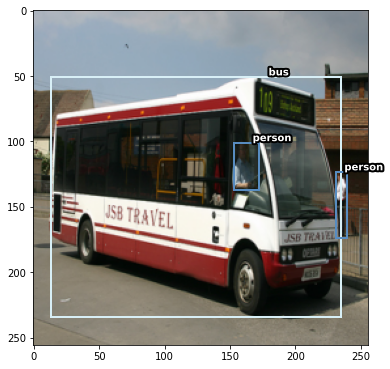

In [ ]:
# Show some images 
no_normalization = Compose(
    [
        Resize((256, 256)),
        ToTensor(),
    ]
)

example_data = VOCDetection(
    "sample_data", download=False, transforms=no_normalization
)


examples = np.random.randint(low=0, high=len(train_data), size=5)
for ex_idx in examples:
  data = example_data[ex_idx]
  bboxes = coordinates_to_center_hw(data[1][:, 1:])
  draw_image_boxes(data[0], bboxes, data[1][:, 0])


## Model

### FPN Extractor

In [ ]:
class ResnetFPNFeatures(nn.Module):
    def __init__(
        self,
        backbone_name="resnet50",
        fpn_channels=256,
        freeze_backbone=True,
    ):
        """
        Feature Pyramid Network features from a pretrained resnet-N model 
        as specified in the paper. 
        Returns a list of all features at all levels.

        Parameters
        ----------
        backbone_name: Optional, str. Default: 'resnet50'
            Name of the backbone to use, loaded from torch hub.
        fpn_channels: Optional, int. Default: 256
            Number of channels used to compute the fpn features.
        freeze_backbone: Optional, bool. Default: True
            Whether to freeze the fpn layers to prevent training the feature extractor.
        """
        super(ResnetFPNFeatures, self).__init__()
        backbone = torch.hub.load(
            "pytorch/vision:v0.10.0", backbone_name, weights=ResNet50_Weights.DEFAULT
        )
        
        del backbone.fc
        self.backbone = backbone

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

        # All 1x1 convolutions
        self.c5_reduce = nn.Conv2d(
            in_channels=2048, out_channels=fpn_channels, kernel_size=1, stride=1
        )
        self.c4_reduce = nn.Conv2d(
            in_channels=1024, out_channels=fpn_channels, kernel_size=1, stride=1
        )
        self.c3_reduce = nn.Conv2d(
            in_channels=512, out_channels=fpn_channels, kernel_size=1, stride=1
        )

        # Feature convolutions
        self.p3_conv = nn.Conv2d(
            in_channels=256,
            out_channels=fpn_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.p4_conv = nn.Conv2d(
            in_channels=256,
            out_channels=fpn_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.p6_conv = nn.Conv2d(
            in_channels=2048,
            out_channels=fpn_channels,
            kernel_size=3,
            stride=2,
            padding=1,
        )
        self.p7_conv = nn.Conv2d(
            in_channels=fpn_channels,
            out_channels=fpn_channels,
            kernel_size=3,
            stride=2,
            padding=1,
        )

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x0 = self.backbone.relu(x)
        x = self.backbone.maxpool(x0)
        x1 = self.backbone.layer1(x)

        # Get the backbone features by feeding normally through the network
        c3 = self.backbone.layer2(x1)
        c4 = self.backbone.layer3(c3)
        c5 = self.backbone.layer4(c4)

        # Get the computed features by 1x1 conv and upsampling bottom-up
        p5 = self.c5_reduce(c5)
        p4 = self.upsample(p5) + self.c4_reduce(c4)
        p3 = self.upsample(p4) + self.c3_reduce(c3)

        # Get the computed features
        p3 = self.p3_conv(p3)
        p4 = self.p4_conv(p4)

        p6 = self.p6_conv(c5)  # P6 is obtained via a 3×3 stride-2 conv on C5
        p7 = self.p7_conv(
            F.relu(p6)
        )  # P7 is computed by applying ReLU followed by a 3×3 stride-2 conv on P6

        return [p3, p4, p5, p6, p7]


### Anchors

In [ ]:
def generate_anchors(base_size, ratios=None, scales=None):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales w.r.t. a reference window.
    """

    if ratios is None:
        ratios = np.array([0.5, 1, 2])
    if scales is None:
        scales = np.array([2**0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])
    num_anchors = len(ratios) * len(scales)

    # initialize output anchors
    anchors = np.zeros((num_anchors, 4))

    # scale base_size
    anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T

    # compute areas of anchors
    areas = anchors[:, 2] * anchors[:, 3]

    # correct for ratios
    anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
    anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))

    # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
    anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
    anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

    return anchors


In [ ]:
def shift(shape, stride, anchors):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack(
        (shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel())
    ).transpose()

    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    A = anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose(
        (1, 0, 2)
    )
    all_anchors = all_anchors.reshape((K * A, 4))

    return all_anchors


In [ ]:
class Anchors(nn.Module):
    def __init__(
        self, pyramid_levels=None, strides=None, sizes=None, ratios=None, scales=None
    ):
        """
        Generates all anchors for a batch of images and a given set of pyramid levels, strides, sizes and ratios.
        All values default to the ones specified in the paper.

        Parameters
        ----------
        pyramid_levels: list, optional. Default None
            Pyramid levels to generate anchors for. 
        strides: list, optional. Default None
            Stride sizes for the passed pyramid_levels.
        sizes: list, optional. Default None
            Anchor sizes for the passed pyramid_levels.
        ratios: list, optional. Default None
            Anchor box ratios, normally [0.5, 1, 2]
        scales: list, optional. Default None
            Anchor box scales to use for the generated anchors.
        """
        super(Anchors, self).__init__()
        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        if strides is None:
            self.strides = [2**x for x in self.pyramid_levels]
        if sizes is None:
            self.sizes = [2 ** (x + 2) for x in self.pyramid_levels]
        if ratios is None:
            self.ratios = np.array([0.5, 1, 2])
        if scales is None:
            self.scales = np.array([2**0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    def forward(self, image):
        image_shapes = self.__compute_shapes(image.shape)

        # compute anchors over all pyramid levels
        all_anchors = np.zeros((0, 4)).astype(np.float32)
        for idx, p in enumerate(self.pyramid_levels):
            anchors = generate_anchors(
                base_size=self.sizes[idx], ratios=self.ratios, scales=self.scales
            )
            shifted_anchors = shift(image_shapes[idx], self.strides[idx], anchors)
            all_anchors = np.append(all_anchors, shifted_anchors, axis=0)
        all_anchors = np.expand_dims(all_anchors, axis=0)

        return torch.tensor(all_anchors.astype(np.float32))

    def __compute_shapes(self, image_shape):
        image_shape = np.array(image_shape[2:])
        image_shapes = [
            (image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels
        ]
        return image_shapes


### Regression and Classification Heads

In [ ]:
class RetinanetClassificationHead(nn.Module):
    """
    The classification subnet predicts
    the probability of object presence at each spatial position
    for each of the A anchors and K object classes. This subnet
    is a small FCN attached to each FPN level; parameters of
    this subnet are shared across all pyramid levels.
    Its design is simple => Taking an input feature map with C channels
    from a given pyramid level, the subnet applies four 3×3
    conv layers, each with C filters and each followed by ReLU
    activations, followed by a 3×3 conv layer with KA filters.
    Finally sigmoid activations are attached to output the KA
    binary predictions per spatial location, see Figure 3 (c). We
    use C = 256 and A = 9 in most experiments.
    """

    def __init__(self, n_classes, channels=256, anchors=9, prior_init=0.01):
        super(RetinanetClassificationHead, self).__init__()
        self.channels = channels
        self.anchors = anchors
        self.n_classes = n_classes

        modules = [
            nn.Conv2d(
                in_channels=self.channels,
                out_channels=self.channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
        ] * 4
        self.conv_stack = nn.Sequential(*modules)
        self.final_conv = nn.Conv2d(
            in_channels=self.channels,
            out_channels=self.n_classes * self.anchors,
            kernel_size=3,
            stride=1,
            padding=1,
        )

    def forward(self, image_batch):
        out = self.conv_stack(image_batch)
        out = self.final_conv(out)

        # out is B x C x W x H, with C = n_classes + anchors
        out = out.permute(0, 2, 3, 1)

        batch_size, width, height, channels = out.shape

        out = out.view(batch_size, width, height, self.anchors, self.n_classes)

        return out.contiguous().view(image_batch.shape[0], -1, self.n_classes)


In [ ]:
class RetinanetRegressionHead(nn.Module):
    """
    In parallel with the object classification subnet, 
    we attach another small FCN to each pyramid level for the purpose of 
    regressing the offset from each anchor box to a nearby 
    ground-truth object, if one exists.
    The design of the box regression subnet is identical to the
    classification subnet except that it terminates in 4A linear
    outputs per spatial location, see Figure 3 (d). For each
    of the A anchors per spatial location, 
    these 4 outputs predict the relative offset between 
    the anchor and the groundtruth box
    """

    def __init__(self, channels=256, anchors=9):
        super(RetinanetRegressionHead, self).__init__()
        self.channels = channels
        self.anchors = anchors

        modules = [
            nn.Conv2d(
                in_channels=self.channels,
                out_channels=self.channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
        ] * 4
        self.conv_stack = nn.Sequential(*modules)
        self.final_conv = nn.Conv2d(
            in_channels=self.channels,
            out_channels=4 * self.anchors,
            kernel_size=3,
            stride=1,
            padding=1,
        )
    
    def forward(self, image_batch):
      out = self.conv_stack(image_batch)
      out = self.final_conv(out)

      # out is B x C x W x H, with C = 4 * num_anchors
      out = out.permute(0, 2, 3, 1)
      return out.contiguous().view(out.shape[0], -1, 4)      


### RetinaNet

In [ ]:
class RetinaNet(nn.Module):
    """
    Put it all together.

    Get the features from the FPN at all levels and pass them to the two heads.
    Generate the anchor boxes for the image batch.
    """
    def __init__(self, num_classes: int):
        super(RetinaNet, self).__init__()

        self.feature_extractor = ResnetFPNFeatures()
        self.anchors = Anchors()

        self.classification_head = RetinanetClassificationHead(n_classes=num_classes)
        self.regression_head = RetinanetRegressionHead()

    def forward(self, image_batch):
        features = self.feature_extractor(image_batch)

        image_anchors = self.anchors(image_batch)

        regression_predictions = torch.cat(
            [self.regression_head(feature) for feature in features], dim=1
        )
        classification_predictions = torch.cat(
            [self.classification_head(feature) for feature in features], dim=1
        )

        return regression_predictions, classification_predictions, image_anchors


## Loss function

Takes all model outputs and targets to compute the regression+classification model loss


In [ ]:
def compute_classification_loss(
    predicted_classification,
    bbox_annotation,
    bbox_label,
    max_iou,
    iou_argmax,
    positive_indices,
    alpha,
    gamma,
):
    """
    Computes Focal Classification loss based on MulticlassCrossEntropy.

    Parameters
    ----------
      predicted_classification: torch.tensor, shape [N_Anchors, N_Classes]
        Predicted classifications from the model for a single image.
        
      bbox_annotation: torch.tensor of shape [N, 4]
        Bounding box annotations for the current image.

      bbox_label: torch.tensor of shape [N]
        Labels for the bounding boxes.

      max_iou: torch.tensor of shape [N_anchors]
        Max values for the ious between anchors and target BBoxes.

      iou_argmax: torch.tensor of shape [N_anchors]
        Indices of the max values above.

      positive_indices: torch.tensor of shape [N_anchors]
        Indices where the iou is over a threshold.

      alpha: float
        Alpha parameter in focal loss paper.

      gamma: float
        Gamma parameter in focal loss paper.
    """
    if bbox_annotation.shape[0] == 0:
        targets = torch.zeros(predicted_classification.shape).to(device)

    else:
        targets = (torch.ones(predicted_classification.shape[0]) * -1).long().to(device)
        targets[torch.lt(max_iou, 0.4)] = 0

        targets[positive_indices] = 0
        targets[positive_indices] = bbox_label[iou_argmax][positive_indices].long().to(device)

    cross_entropy_loss = F.cross_entropy(predicted_classification, targets, reduction='none', ignore_index=-1)
    prob = torch.exp(-cross_entropy_loss)
    focal_loss = alpha * (1 - prob) ** gamma * cross_entropy_loss
    
    return focal_loss.mean()

In [ ]:

def compute_regression_loss(
    predicted_regression,
    anchor,
    target_bboxes,
    iou_argmax,
    positive_indices,
):
    """
    Computes the bounding box regression loss from the retinanet paper.

    Parameters
    ----------
    predicted_regression: torch.tensor of shape [N_Anchors, 4]
      The predicted bounding boxes for each anchor.

    anchor: torch.tensor of shape [N_Anchors, 4]
      All anchors for current image.

    target_bboxes: torch.tensor of shape [N, 4]
      Target bounding boxes for current image.
    
    iou_argmax: torch.tensor of shape [N_anchors]
      Indices of the max values above.

    positive_indices: torch.tensor of shape [N_anchors]
      Indices where the iou is over a threshold.
    """
    # No objects in the image all predictions should be background
    if target_bboxes.shape[0] == 0:
      return torch.tensor(0).float().to(device)

    regression_loss = torch.tensor(0).float().to(device)

    if positive_indices.sum() > 0:
        assigned_annotations = target_bboxes[iou_argmax][positive_indices, :]

        anchor_widths = anchor[:, 2] - anchor[:, 0]
        anchor_heights = anchor[:, 3] - anchor[:, 1]
        anchor_ctr_x = anchor[:, 0] + 0.5 * anchor_widths
        anchor_ctr_y = anchor[:, 1] + 0.5 * anchor_heights

        anchor_widths_pi = anchor_widths[positive_indices]
        anchor_heights_pi = anchor_heights[positive_indices]
        anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
        anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

        gt_widths = assigned_annotations[:, 2] - assigned_annotations[:, 0]
        gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
        gt_ctr_x = assigned_annotations[:, 0] + 0.5 * gt_widths
        gt_ctr_y = assigned_annotations[:, 1] + 0.5 * gt_heights

        # clip widths to >1
        gt_widths = torch.clamp(gt_widths, min=1)
        gt_heights = torch.clamp(gt_heights, min=1)

        targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / anchor_widths_pi
        targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / anchor_heights_pi
        targets_dw = torch.log(gt_widths / anchor_widths_pi)
        targets_dh = torch.log(gt_heights / anchor_heights_pi)

        targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh))
        targets = targets.t().to(device)

        targets = targets / torch.Tensor([[0.1, 0.1, 0.2, 0.2]]).to(device)

        negative_indices = 1 + (~positive_indices)

        regression_diff = torch.abs(targets - predicted_regression[positive_indices, :])

        regression_loss = torch.where(
            torch.le(regression_diff, 1.0 / 9.0),
            0.5 * 9.0 * torch.pow(regression_diff, 2),
            regression_diff - 0.5 / 9.0,
        )

    return regression_loss.mean()


In [ ]:
def retinanet_loss(
    classification_predictions,
    regression_predictions,
    anchors,
    target_bboxes,
    target_labels,
    alpha=0.25,
    gamma=2.0,
):
    """
    Combines the classification and regression losses for all images in a batch.
    """
    batch_size = classification_predictions.shape[0]
    classification_losses = []
    regression_losses = []

    anchor = anchors[0, :, :]

    for j in range(batch_size):
        predicted_classification = classification_predictions[j, :, :]
        predicted_regression = regression_predictions[j, :, :]

        bbox_annotation = target_bboxes[j]
        bbox_label = target_labels[j]

        # Compute bbox ious
        ious = box_iou(
            anchors[0, :, :], bbox_annotation
        )  # num_anchors x num_annotations
        max_iou, iou_argmax = torch.max(ious, dim=1)  # num_anchors x 1

        positive_indices = torch.ge(max_iou, 0.5)

        classification_losses.append(
            compute_classification_loss(
                predicted_classification,
                bbox_annotation,
                bbox_label,
                max_iou,
                iou_argmax,
                positive_indices,
                alpha,
                gamma,
            )
        )

        regression_losses.append(
            compute_regression_loss(
                predicted_regression,
                anchor,
                bbox_annotation,
                iou_argmax,
                positive_indices,
            )
        )

    return torch.stack(classification_losses).mean(dim=0, keepdim=True), torch.stack(
        regression_losses
    ).mean(dim=0, keepdim=True)


## Training

In [ ]:
def train_epoch(
    model,
    optimizer,
    dataloader,
    loss,
):
    model.train()
    epoch_clf_loss = 0
    epoch_regression_loss = 0

    for input_images, bboxes, bbox_labels in dataloader:
        optimizer.zero_grad()

        regression_predictions, classification_predictions, image_anchors = model(
            input_images.to(device)
        )
        classification_cost, regression_cost = loss(
            classification_predictions, regression_predictions, image_anchors, bboxes, bbox_labels
        )
        epoch_clf_loss += classification_cost.item()
        epoch_regression_loss += regression_cost.item()

        (classification_cost + regression_cost).backward()
        optimizer.step()

    return epoch_clf_loss / len(dataloader), epoch_regression_loss / len(dataloader)


def test_epoch(
    model,
    optimizer,
    dataloader,
    loss,
):
    model.eval()
    epoch_clf_loss = 0
    epoch_regression_loss = 0

    with torch.no_grad():
        for input_images, bboxes, bbox_labels in dataloader:
            regression_predictions, classification_predictions, image_anchors = model(
                input_images.to(device)
            )
            classification_cost, regression_cost = loss(
              classification_predictions, regression_predictions, image_anchors, bboxes, bbox_labels
            )
            epoch_clf_loss += classification_cost.item()
            epoch_regression_loss += regression_cost.item()

    return epoch_clf_loss / len(dataloader), epoch_regression_loss / len(dataloader)


In [ ]:
def od_train(
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    epochs=50,
):
    clf_train_loss_hist = []
    regression_train_loss_hist = []
    clf_val_loss_hist = []
    regression_val_loss_hist = []

    loss_function = retinanet_loss

    for epoch in range(epochs):
        start = time.time()
        clf_train_loss, regression_train_loss = train_epoch(
            model, optimizer, train_dataloader, loss_function
        )
        clf_train_loss_hist.append(clf_train_loss)
        regression_train_loss_hist.append(regression_train_loss)

        clf_val_loss, regression_val_loss = test_epoch(
            model, optimizer, train_dataloader, loss_function
        )
        clf_val_loss_hist.append(clf_val_loss)
        regression_val_loss_hist.append(regression_val_loss)

        print(
            f"Epoch {epoch + 1} | "
            f"Train Classification Loss {clf_train_loss:.6f} | "
            f"Train Regression Loss {regression_train_loss:.6f} | "
            f"Val Classification Loss {clf_val_loss:.6f} | "
            f"Val Regression Loss {regression_val_loss:.6f} | "
            f"Time {time.time() - start:.2f} sec"
        )
    return (
        clf_train_loss_hist,
        regression_train_loss_hist,
        clf_val_loss_hist,
        regression_val_loss_hist,
    )


## Results

In [ ]:
PASCAL_VOC_CLASSES = len(VOC_CLASSES)


def collate_fn(batch):
    """
    Custom collate function since 
    images can have different number 
    of objects in them
    """    
    images = []
    boxes = []
    labels = []
    for b in batch:
        images.append(b[0])
        combined_bbox_info = b[1]
        boxes.append(combined_bbox_info[:, 1:])
        labels.append(combined_bbox_info[:, 0])
    return torch.stack(images), boxes, labels


# Define dataloaders
train_dataloader = DataLoader(
    train_data, batch_size=32, num_workers=2, pin_memory=True, collate_fn=collate_fn
)
val_dataloader = DataLoader(
    test_data, batch_size=32, num_workers=2, pin_memory=True, collate_fn=collate_fn
)

# Define model and optimizer
model = RetinaNet(num_classes=PASCAL_VOC_CLASSES).to(device)
net_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
N_EPOCHS = 10

train_clf_losses, train_reg_losses, val_clf_losses, val_reg_losses = od_train(
    model, net_optimizer, train_dataloader, val_dataloader, epochs=N_EPOCHS
)


Epoch 1 | Train Classification Loss 0.016077 | Train Regression Loss 0.828626 | Val Classification Loss 0.005016 | Val Regression Loss 0.671924 | Time 159.69 sec
Epoch 2 | Train Classification Loss 0.004563 | Train Regression Loss 0.634482 | Val Classification Loss 0.004217 | Val Regression Loss 0.570351 | Time 155.69 sec
Epoch 3 | Train Classification Loss 0.003952 | Train Regression Loss 0.559212 | Val Classification Loss 0.003695 | Val Regression Loss 0.503292 | Time 155.20 sec
Epoch 4 | Train Classification Loss 0.003589 | Train Regression Loss 0.508324 | Val Classification Loss 0.003284 | Val Regression Loss 0.484766 | Time 157.38 sec
Epoch 5 | Train Classification Loss 0.003271 | Train Regression Loss 0.475551 | Val Classification Loss 0.002880 | Val Regression Loss 0.457869 | Time 155.08 sec
Epoch 6 | Train Classification Loss 0.002960 | Train Regression Loss 0.448798 | Val Classification Loss 0.002543 | Val Regression Loss 0.456690 | Time 154.24 sec
Epoch 7 | Train Classificati

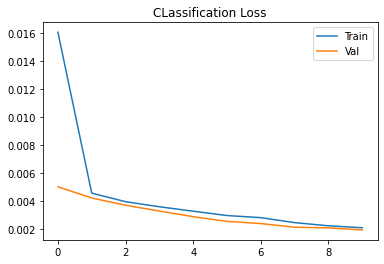

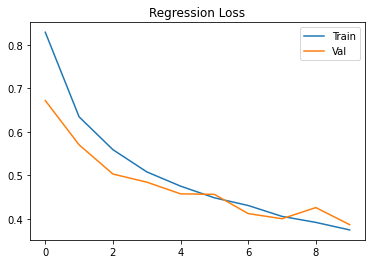

In [ ]:
plt.plot(range(N_EPOCHS), train_clf_losses, label="Train")
plt.plot(range(N_EPOCHS), val_clf_losses, label="Val")
plt.legend()
plt.title("CLassification Loss")
plt.show()

plt.plot(range(N_EPOCHS), train_reg_losses, label="Train")
plt.plot(range(N_EPOCHS), val_reg_losses, label="Val")
plt.legend()
plt.title("Regression Loss")
plt.show()


## Visualizations

In [ ]:
class BBoxTransform(nn.Module):
    def __init__(self, mean=None, std=None):
        super(BBoxTransform, self).__init__()
        if mean is None:
            self.mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32))
        if std is None:
            self.std = torch.from_numpy(
                np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32)
            )

    def forward(self, boxes, deltas):
        widths = boxes[:, :, 2] - boxes[:, :, 0]
        heights = boxes[:, :, 3] - boxes[:, :, 1]
        ctr_x = boxes[:, :, 0] + 0.5 * widths
        ctr_y = boxes[:, :, 1] + 0.5 * heights

        dx = deltas[:, :, 0] * self.std[0] + self.mean[0]
        dy = deltas[:, :, 1] * self.std[1] + self.mean[1]
        dw = deltas[:, :, 2] * self.std[2] + self.mean[2]
        dh = deltas[:, :, 3] * self.std[3] + self.mean[3]

        pred_ctr_x = ctr_x + dx * widths
        pred_ctr_y = ctr_y + dy * heights
        pred_w = torch.exp(dw) * widths
        pred_h = torch.exp(dh) * heights

        pred_boxes_x1 = pred_ctr_x - 0.5 * pred_w
        pred_boxes_y1 = pred_ctr_y - 0.5 * pred_h
        pred_boxes_x2 = pred_ctr_x + 0.5 * pred_w
        pred_boxes_y2 = pred_ctr_y + 0.5 * pred_h

        pred_boxes = torch.stack(
            [pred_boxes_x1, pred_boxes_y1, pred_boxes_x2, pred_boxes_y2], dim=2
        )

        return pred_boxes


class ClipBoxes(nn.Module):
    def __init__(self, width=None, height=None):
        super(ClipBoxes, self).__init__()

    def forward(self, boxes, img):
        batch_size, num_channels, height, width = img.shape

        boxes[:, :, 0] = torch.clamp(boxes[:, :, 0], min=0)
        boxes[:, :, 1] = torch.clamp(boxes[:, :, 1], min=0)

        boxes[:, :, 2] = torch.clamp(boxes[:, :, 2], max=width)
        boxes[:, :, 3] = torch.clamp(boxes[:, :, 3], max=height)

        return boxes


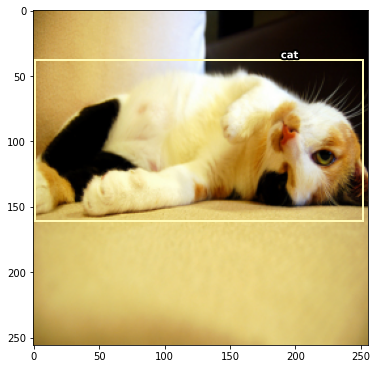

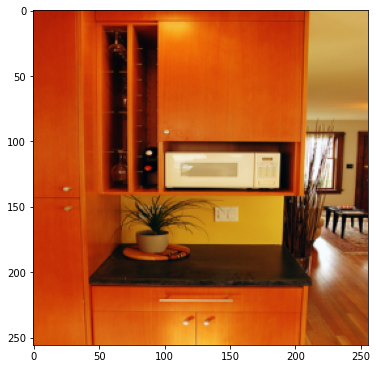

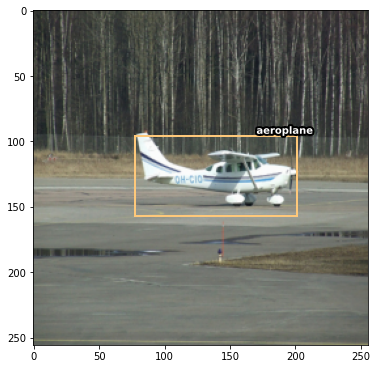

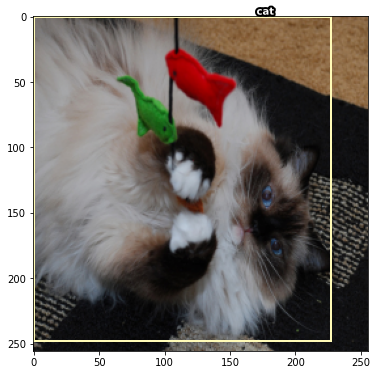

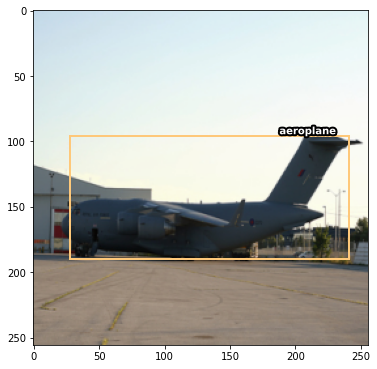

In [ ]:
model.eval()

regress_boxes = BBoxTransform()
clip_boxes = ClipBoxes()

un_normalize = transforms.Normalize(
    (-torch.tensor(imagenet_mean) / torch.tensor(imagenet_std)).tolist(),
    (1.0 / torch.tensor(imagenet_std)).tolist(),
)

# Show some images
example_data = VOCDetection(
    "sample_data", download=False, transforms=basic_augmentation
)


examples = np.random.randint(low=0, high=len(train_data), size=5)
for ex_idx in examples:
    data = example_data[ex_idx]
    image = (data[0][None, :]).to(device)

    with torch.no_grad():
        bbox_predictions, classification_predictions, anchors = model(image.to(device))
        classification_predictions = torch.softmax(classification_predictions, dim=2)
        bbox_predictions, classification_predictions, anchors = bbox_predictions.cpu(), classification_predictions.cpu(), anchors.cpu()
        scores, class_indexes = torch.max(classification_predictions, dim=2)

    # Remove noisy predictions
    keep_scores = scores > 0.09
    anchors, scores, class_indexes, bbox_predictions = (
        anchors[keep_scores],
        scores[keep_scores],
        class_indexes[keep_scores],
        bbox_predictions[keep_scores],
    )

    if len(scores > 0):
        # Revert bboxes
        bbox_predictions = regress_boxes(
            anchors[None, :], bbox_predictions[None, :]
        )
        bbox_predictions = clip_boxes(bbox_predictions, image)

        # Remove background preds
        non_background = class_indexes > 0
        bbox_predictions, class_indexes, scores = (
            bbox_predictions[0][non_background],
            class_indexes[non_background],
            scores[non_background],
        )

        # Apply non-maximum suppression to filter out overlapping boxes
        keep = nms(bbox_predictions, scores, iou_threshold=0.3)
        bbox_predictions, class_indexes = (
            bbox_predictions[keep],
            class_indexes[keep],
        )

    bboxes = coordinates_to_center_hw(bbox_predictions)
    # Un-normalize image
    image = (un_normalize(image[0].cpu())*255).to(torch.uint8)
    draw_image_boxes(image, bboxes, class_indexes)
